In [46]:
import datetime
import pandas as pd
from pandas_datareader import data as wb
import numpy as np
import quandl
from pandas import ExcelWriter
import matplotlib.pyplot as plt
from arch import arch_model
from scipy.stats import t
from statsmodels.distributions.empirical_distribution import ECDF
from scipy import stats as scipy_stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
plt.style.use('bmh')
from sklearn import tree
import statsmodels.tsa.stattools as ts

In [47]:
Ticker=['^GSPC']
print(Ticker,len(Ticker))
df_=pd.DataFrame()
for i in Ticker:
    df_=wb.DataReader(i,'yahoo', start='1900-01-01')

f = df_['Adj Close'].pct_change().dropna()

['^GSPC'] 1


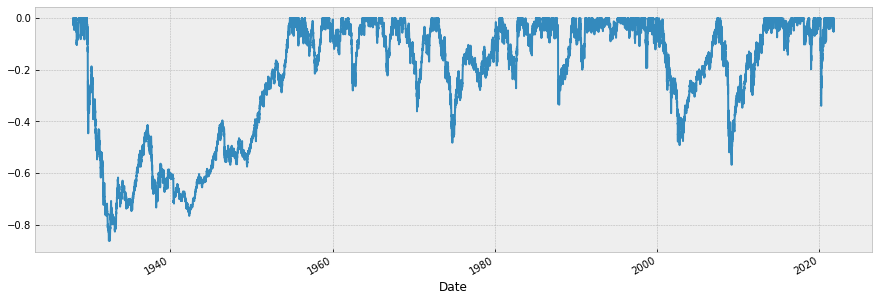

In [48]:
#Plot Drawdowns We will use it as a stress test
cmp = np.cumprod(1 + f)
drawdowns = cmp/cmp.cummax() - 1
drawdowns.plot(figsize=(15,5))
idx = drawdowns[drawdowns<-0.10].dropna().resample('1M').last().index

In [49]:
# Features construction 
df_['Open-Close'] = (df_.Open - df_.Close)/df_.Open
df_['High-Low'] = (df_.High - df_.Low)/df_.Low
df_['percent_change'] = df_['Adj Close'].pct_change()
df_['std_5'] = df_['percent_change'].rolling(5).std()
df_['ret_5'] = df_['percent_change'].rolling(5).mean()
df_.dropna(inplace=True)

# X is the input variable
X = df_[['Open-Close', 'High-Low', 'std_5', 'ret_5']]

# Y is the target or output variable
y = np.where(df_['Adj Close'].shift(-1) > df_['Adj Close'], 1, -1)

In [50]:
df_['MA200'] = df_['Close'].rolling(200).mean()
df_['Pct_change'] = df_['Close'].pct_change()
df_['Cum Prod change'] = (df_['Pct_change']).resample('1M').apply(lambda x : np.prod(1+x) - 1)
df_.dropna(inplace=True)

# Features construction 
X = pd.DataFrame(np.where(df_['Close'] > df_['MA200'],1,-1),index=df_.index)

y = pd.DataFrame(np.where(df_['Cum Prod change'] > 0,1,-1),index=df_.index)


In [51]:
#Check if we can Reject the Hypothesis of non-stationarity 
tst1,tst2 = ts.adfuller(X),ts.adfuller(y)
print('X is stationary because the adf test coefficient {} < {} at a confidence of 99%'.format(tst1[0],tst1[4].get('1%')))
print('y is stationary because the adf test coefficient {} < {} at a confidence of 99%'.format(tst2[0],tst2[4].get('1%')))

X is stationary because the adf test coefficient -9.431279682358065 < -3.4388159246521433 at a confidence of 99%
y is stationary because the adf test coefficient -14.331193346982252 < -3.438804978547988 at a confidence of 99%


In [52]:
clf = tree.DecisionTreeClassifier(random_state=5)
model = clf.fit(X, y)

In [53]:
from sklearn.metrics import accuracy_score
print('Correct Prediction: ', accuracy_score(y, model.predict(X), normalize=False))
print('Total Prediction: ', X.shape[0])
print(accuracy_score(y, model.predict(X), normalize=True)*100)

Correct Prediction:  554
Total Prediction:  779
71.1168164313222


In [54]:
dataset_length = df_.shape[0]

# Training dataset length
split = int(dataset_length * 0.75)
split

584

In [55]:
# Splittiing the X and y into train and test datasets
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Print the size of the train and test dataset
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

(584, 1) (195, 1)
(584, 1) (195, 1)


In [56]:
model = clf.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test), normalize=True)*100

71.28205128205128

# During Period of high stress :

In [43]:
#2008 GFC (Global Financial Crisis)
X_test,y_test = X.loc['2007-01-01':'2009-01-01'],y.loc['2007-01-01':'2009-01-01']
model = clf.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test), normalize=True)*100

77.77777777777779

In [44]:
#Internet Bubble (Dotcom Bubble)
X_test,y_test = X.loc['2000-01-01':'2002-01-01'],y.loc['2000-01-01':'2002-01-01']
model = clf.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test), normalize=True)*100

44.44444444444444

In [71]:
#CoronaVirus Crisis
X_test,y_test = X.loc['2020-01-01':'2021-10-20'],y.loc['2020-01-01':'2021-10-20']
model = clf.fit(X_train, y_train)
accuracy_score(y_test, model.predict(X_test), normalize=True)*100

71.42857142857143